# Targeted Attacking to the Traffic Sign Classifier

__Objective__: Attack the model with targeted attacks using **Cleverhans** attack library.

__Workflow__:
1.  Load the `Traffic Sign` dataset and examine its structure.
    - Download `tsrd-train` from http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html.
    - Take a closer look at the data inspecting it's size, shape, and quantity.
    - View some random samples using either OpenCV or Matplotlib (or others) of the handwritten digits and observe the complexity of the images. Do you have any issues identify these written numbers?
2. Using `numpy` or other libraries prepare your dataset for training
    - Ensure the format or shape of the data is appropriate for input into your model (one-hot-encoding is needed for the labels)
    - Ensure data types are correct and that data is normalized. 
3. Load model that is trained in the previous project using Keras' `load_model` method
4. Generate malicious inputs
   - Convert Keras model to Tensorflow's `tf.keras.Model` class. **Note that**, this is different from the previous project.
   - Projected Gradient Descent attack
      - Generate malicious inputs based on X_train and Projected Gradient Descent (PGD) attack using Cleverhan's `projected_gradient_descent` class with 0.08 epsilon value
      - Generate malicious inputs based on X_train and random uniform noise using `np.random.uniform` with -0.08 and 0.08 (e.g. same epsilon value)
         - Use only the first 100 samples from X_train. PGD is a powerfull attacks. The malicious input generation will take lots of time.
         - The target class is `3`
      - Select first 8 images from test dataset, Plot random 24 images (e.g. 3 rows and 8 columns).
         - First row shows the original images with the predicted labels
         - Second row shows the PGD based manipulated images with the predicted labels
         - Third row shows the `random uniform` manipulated images with the predicted labels
   - Basic Iterative Method attack
      - Generate malicious inputs based on X_train and Basic Iterative Method (BIM) attack using Cleverhan's  `basic_iterative_method` class with 0.08 epsilon value
      - Generate malicious inputs based on X_train and random uniform noise using `np.random.uniform` with -0.03 and 0.03 (e.g. same epsilon value)
      - Select first 8 images from test dataset, Plot random 24 images (e.g. 3 rows and 8 columns).
         - First row shows the original images with the predicted labels
         - Second row shows the BIM based manipulated images with the predicted labels
         - Third row shows the `random uniform` manipulated images with the predicted labels
   - Carlini & Wagner attack
      - Generate malicious inputs based on X_train and Carlini and Wagner (C&W) attack using Cleverhan's  `carlini_wagner_l2` class
         - C&W attack is different than previous PGD and BIM attacks. The important parameters are `confidence`, `abort_early`, and  `max_iterations`. There is no `epsilon` parameter in this attack.
         - C&W is the most powerful (e.g. successful) attack in Adversarial Machine Learning attacks. On the other hand, it takes time to generate malicious inputs, and in this project, we will generate only 8 malicious inputs for this attack.
      - Select first 8 images from test dataset, Plot random 24 images (e.g. 3 rows and 8 columns).
         - First row shows the original images with the predicted labels
         - Second row shows the BIM based manipulated images with the predicted labels
         - Third row shows the `random uniform` manipulated images with the predicted labels


__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow. You should save `trainX,testX,trainY,testY,predictions,x_test_adv_fgsm,y_adv_pred_fgsm,x_test_adv_pgd,y_adv_pred_pgd` numpy matrices as you'll need it for further analysis in the second milestone.

In [1]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2

from keras.models import load_model
from art.estimators.classification import KerasClassifier
import tensorflow as tf
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import cv2
import os
from keras.preprocessing.image import  img_to_array
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
IMAGE_PATH_TRAIN = '/Users/ozgur/Downloads/tsrd-train/'
COL_NAMES = ['filename','f1','f2','x1','y1','x2','y2','label']
IMAGE_SIZE = (134,128)
EPOCHS = 30
BS = 100
MODEL_NAME = 'cnn-traffic-sign.h5'

In [3]:
# Step 1
model = load_model(MODEL_NAME)

In [4]:
# Step 2: Create the logit model from tf.keras.Model
logits_model = tf.keras.Model(model.input, model.layers[-1].output)

In [5]:
df = pd.read_csv('TsignRecgTrain4170Annotation.txt',names=COL_NAMES,sep=';', index_col=False)

files = glob(IMAGE_PATH_TRAIN + '*.png')
data = []
labels = []

for fname in tqdm(range(len(files)),):
    fname = files[fname]
    image = cv2.imread(fname)
    image = cv2.resize(image, IMAGE_SIZE)
    image = img_to_array(image)
    data.append(image)
    
    label = df.query("filename=='" + os.path.split(fname)[1] + "'").label.values[0]
    labels.append(label)
    
data = np.array(data) / 255.0
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

  0%|          | 0/4170 [00:00<?, ?it/s]

In [6]:
predictions = model.predict(testX)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(testY, axis=1)) / len(testY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.28057553956835%


In [7]:
# Step 3: Generate adversarial test examples with **targeted Projected Gradient Descent** attack
ATTACK_POWER = 0.08
NUMBER_OF_MALICIOUS_INPUTS = 100
TARGET_CLASS = 3

y_attack_target = (np.ones((NUMBER_OF_MALICIOUS_INPUTS,)) * TARGET_CLASS).astype(int)

x_test_adv_pgd = projected_gradient_descent(logits_model, testX[0:NUMBER_OF_MALICIOUS_INPUTS,:],
                                            eps=ATTACK_POWER, norm=np.inf, nb_iter=100, 
                                            eps_iter=ATTACK_POWER/10.0, targeted=True,
                                           y=y_attack_target)

In [8]:
# Step 4: Evaluate the the classifier on adversarial test examples
y_adv_pred_pgd = model.predict(x_test_adv_pgd[0:NUMBER_OF_MALICIOUS_INPUTS])
attack_success_ratio = np.sum(np.argmax(y_adv_pred_pgd, axis=1) == TARGET_CLASS) / NUMBER_OF_MALICIOUS_INPUTS
print("Attack success ratio on first %i adversarial test samples: %f" % (NUMBER_OF_MALICIOUS_INPUTS, attack_success_ratio))

Attack success ratio on first 100 adversarial test samples: 0.360000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


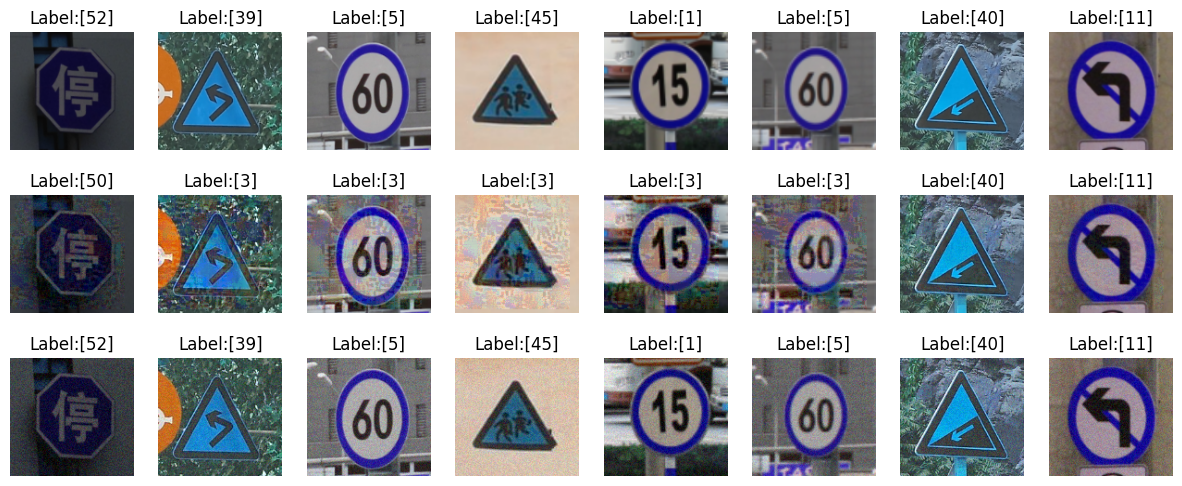

In [9]:
# Step 5: Plot original, noisy and malicious inputs
NUM_OF_ROWS = 3
NUM_OF_COLS = 8
fig, ax = plt.subplots(NUM_OF_ROWS,NUM_OF_COLS, figsize=(15,6))

for i in range(NUM_OF_COLS):
    uniform_noise = np.random.uniform(low=-1.0,high=1.0,size=testX[i].shape) * ATTACK_POWER
    noise = testX[i:i+1] + uniform_noise
    
    benign_pred = model.predict(testX[i:i+1])
    malicious_pred = model.predict(x_test_adv_pgd[i:i+1])
    noise_pred = model.predict(noise)

    ax[0,i].imshow(testX[i])
    ax[1,i].imshow(x_test_adv_pgd[i])
    ax[2,i].imshow(noise[0].clip(0.0,1.0))

    ax[0,i].set_title('Label:' + str(benign_pred.argmax(axis=1)))
    ax[1,i].set_title('Label:' + str(malicious_pred.argmax(axis=1)))
    ax[2,i].set_title('Label:' + str(noise_pred.argmax(axis=1)))
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
plt.show()

In [10]:
# Step 6: Generate adversarial test examples with BIM attack
y_attack_target = (np.ones((NUMBER_OF_MALICIOUS_INPUTS,)) * TARGET_CLASS).astype(int)

x_test_adv_bim = basic_iterative_method(logits_model, testX[0:NUMBER_OF_MALICIOUS_INPUTS,:],
                                            eps=ATTACK_POWER, norm=np.inf, nb_iter=100, 
                                            eps_iter=ATTACK_POWER/10.0, targeted=True,
                                           y=y_attack_target)

In [11]:
y_adv_pred_bim = model.predict(x_test_adv_bim)
attack_success_ratio = np.sum(np.argmax(y_adv_pred_bim, axis=1) == TARGET_CLASS) / NUMBER_OF_MALICIOUS_INPUTS
print("Attack success ratio on first %i adversarial test samples: %f" % (NUMBER_OF_MALICIOUS_INPUTS, attack_success_ratio))

Attack success ratio on first 100 adversarial test samples: 0.360000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


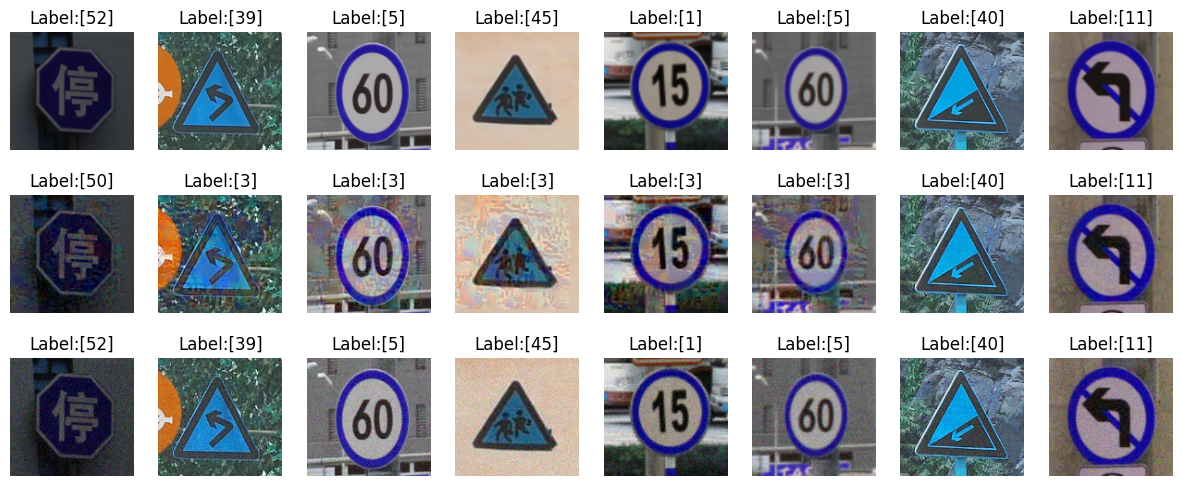

In [12]:
NUM_OF_ROWS = 3
NUM_OF_COLS = 8
fig, ax = plt.subplots(NUM_OF_ROWS,NUM_OF_COLS, figsize=(15,6))

for i in range(NUM_OF_COLS):
    uniform_noise = np.random.uniform(low=-1.0,high=1.0,size=testX[i].shape) * ATTACK_POWER
    noise = testX[i:i+1] + uniform_noise
    
    benign_pred = model.predict(testX[i:i+1])
    malicious_pred = model.predict(x_test_adv_bim[i:i+1])
    noise_pred = model.predict(noise)

    ax[0,i].imshow(testX[i])
    ax[1,i].imshow(x_test_adv_bim[i])
    ax[2,i].imshow(noise[0].clip(0.0,1.0))

    ax[0,i].set_title('Label:' + str(benign_pred.argmax(axis=1)))
    ax[1,i].set_title('Label:' + str(malicious_pred.argmax(axis=1)))
    ax[2,i].set_title('Label:' + str(noise_pred.argmax(axis=1)))
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
plt.show()

In [13]:
# Step 7: Generate adversarial test examples with C&W attack
NUMBER_OF_MALICIOUS_INPUTS = 8
x_test_adv_cw = np.zeros((NUMBER_OF_MALICIOUS_INPUTS,testX.shape[1],testX.shape[2],testX.shape[3]))

for i in tqdm(range(NUMBER_OF_MALICIOUS_INPUTS)):
    tmp = carlini_wagner_l2(logits_model, testX[i:i+1,:],
                            targeted=True, y=[TARGET_CLASS],
                            batch_size=512, confidence=100.0,
                            abort_early=False, max_iterations=10000,
                            clip_min=0.0,clip_max=1.0)

    x_test_adv_cw[i,:] = tmp

  0%|          | 0/8 [00:00<?, ?it/s]

In [14]:
y_adv_pred_cw = model.predict(x_test_adv_cw)
attack_success_ratio = np.sum(np.argmax(y_adv_pred_cw, axis=1) == TARGET_CLASS) / NUMBER_OF_MALICIOUS_INPUTS
print("Attack success ratio on first %i adversarial test samples: %f" % (NUMBER_OF_MALICIOUS_INPUTS, attack_success_ratio))

Attack success ratio on first 8 adversarial test samples: 0.750000


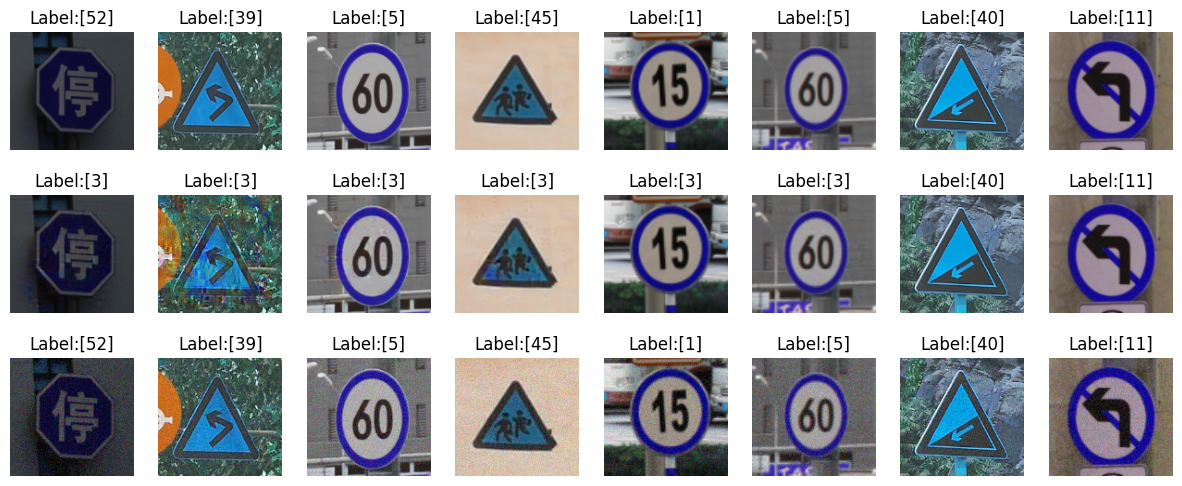

In [15]:
NUM_OF_ROWS = 3
NUM_OF_COLS = 8
fig, ax = plt.subplots(NUM_OF_ROWS,NUM_OF_COLS, figsize=(15,6))

for i in range(NUM_OF_COLS):

    uniform_noise = np.random.uniform(low=-1.0,high=1.0,size=testX[i].shape) * ATTACK_POWER
    noise = testX[i:i+1] + uniform_noise
    
    benign_pred = model.predict(testX[i:i+1])
    malicious_pred = model.predict(x_test_adv_cw[i:i+1])
    noise_pred = model.predict(noise)

    ax[0,i].imshow(testX[i])
    ax[1,i].imshow(x_test_adv_cw[i])
    ax[2,i].imshow(noise[0].clip(0.0,1.0))
    
    ax[0,i].set_title('Label:' + str(benign_pred.argmax(axis=1)))
    ax[1,i].set_title('Label:' + str(malicious_pred.argmax(axis=1)))
    ax[2,i].set_title('Label:' + str(noise_pred.argmax(axis=1)))
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
plt.show()

In [16]:
# Step 7 save matrices

np.savez('milestone-3-1.npz', trainX=trainX, testX=testX,
         trainY=trainY, testY=testY, predictions=predictions,
         x_test_adv_pgd=x_test_adv_pgd,
         y_adv_pred_pgd=y_adv_pred_pgd,
         x_test_adv_bim=x_test_adv_bim,
         y_adv_pred_bim=y_adv_pred_bim,
         x_test_adv_cw=x_test_adv_cw,
        y_adv_pred_cw=y_adv_pred_cw)